This notebook can be run on mybinder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/fchatelain/ExemplesFLO/master?urlpath=lab/tree/1_Wiener_non_causal%2FN1_denoising_chirp_Wiener_smoothing.ipynb)

# Calcule, trace et fait entendre la filtrée de Wiener d'un chirp linéaire noyé dans du bruit

In [1]:
%matplotlib inline
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

In [2]:
SNR = 0  # dB
fs = 5000 # Sampling freq (Hz)

### Chirp generation

In [12]:
f0 = 400. # frequence de depart (Hz)
f1 = 300. # frequence d'arrivee (Hz)

sig_duration= 2. # observed signal duration time (s)
prop_chirp= 5. / 8 # chirp proportion among observed signal
chirp_duration= sig_duration * prop_chirp ; # chirp duration time (s)

sig_len= np.round( sig_duration * fs ).astype(int) + 1 # nb of samples for observed signal
chirp_len= np.round( chirp_duration * fs ).astype(int) + 1 ; # nb of samples for chirp

# Linear frequency modulation for the chirp 
tw = np.linspace(0, chirp_duration, chirp_len ) # time (s)
w = signal.chirp(tw, f0=f0, f1=f1, t1=chirp_duration, method='linear')

# Envelope of the chirp signal 
w = np.hanning(chirp_len) * w 
w = w / np.sqrt(np.mean(w**2)) 

# Final signal containing the chirp 
t= np.linspace(0, sig_duration, sig_len ) # time (s)
sig_chirp= np.zeros(sig_len)
istart= (sig_len* (1-prop_chirp)).astype(int) 
sig_chirp[istart:istart+chirp_len]= w 

### Chirp vizualization

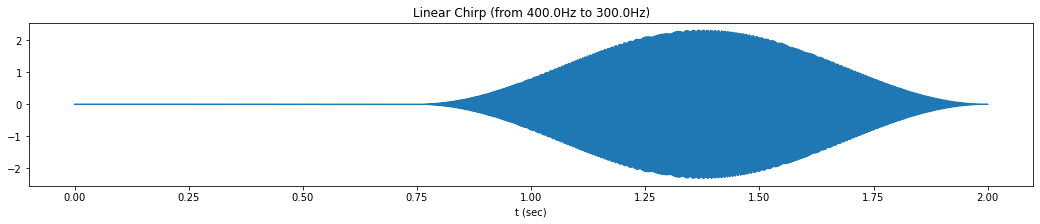

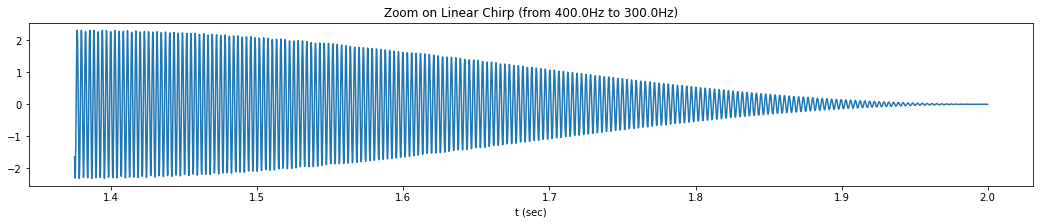

In [13]:

plt.figure(num=1,figsize=(18, 3))
plt.plot(t, sig_chirp)
plt.title("Linear Chirp (from {}Hz to {}Hz)".format(f0,f1) )
plt.xlabel('t (sec)')
plt.show()
# zoom on the chirp part
plt.figure(num=2,figsize=(18, 3))
indplot= np.arange((chirp_len*1/2).astype(int),chirp_len) # plot only a piece of the chirp
plt.plot(t[indplot+istart], sig_chirp[indplot+istart])
plt.title("Zoom on Linear Chirp (from {}Hz to {}Hz)".format(f0,f1) )
plt.xlabel('t (sec)')
plt.show()

### Playing the chirp signal as a sound

In [14]:
# Play chirp signal
from IPython.display import Audio
Audio(sig_chirp / np.max(np.abs(sig_chirp)), rate=fs)

### Observed signal generation

In [15]:
# Additive Gaussian white noise
sigmanoise= np.sqrt((10**(-SNR/10)) * np.mean(sig_chirp**2) )
noise = np.random.normal(scale= sigmanoise, size=t.shape)
sig_obs = sig_chirp + noise

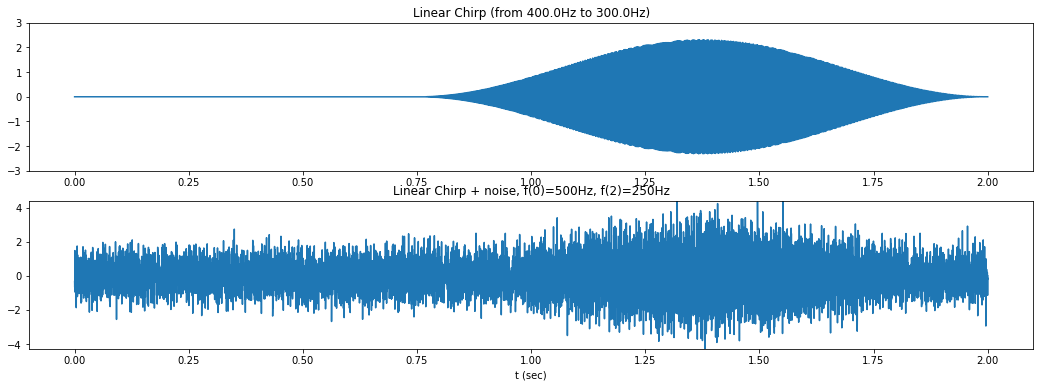

In [16]:
# visualize the chirp to restaure and the observed signal
plt.figure(num=2,figsize=(18, 6))
plt.subplot(2,1,1)
plt.plot(t, sig_chirp)
plt.ylim( -3, 3)   # set the ylim to ymin, ymax
plt.title("Linear Chirp (from {}Hz to {}Hz)".format(f0,f1) )
plt.subplot(2,1,2)
plt.plot(t, sig_obs)
plt.ylim( np.min(sig_obs),np.max(sig_obs) )   # set the ylim to ymin, ymax
plt.title("Linear Chirp + noise, f(0)=500Hz, f(2)=250Hz")
plt.xlabel('t (sec)')
plt.tight_layout
plt.show()

In [17]:
# Play observed signal
from IPython.display import Audio
Audio(sig_obs / np.max(np.abs(sig_obs)), rate=fs)

### Density spectral power and Wiener filter computation

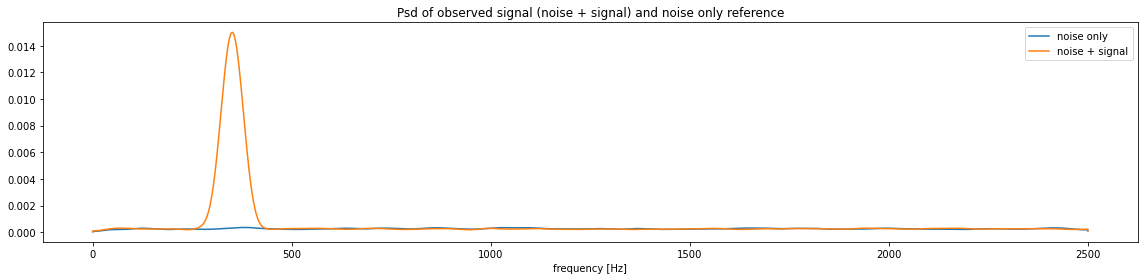

In [18]:
from scipy import signal
nwin= 128
noverlap = 32

# define "noise only" interval and reference y_noise, and observed signal y_sig
istart= 0 
iend= (2*sig_len/5 -1).astype(int)
y_noise = sig_obs[istart:iend]
nref = y_noise.size
y_sig=  sig_obs[(iend+1):] 

# dsp of noise only reference 
fv, Pvv_den = signal.welch(y_noise, fs, window=signal.get_window('hanning', nwin), noverlap=noverlap, nfft=2*sig_len)

# dsp of observed signal
fy, Pyy_den = signal.welch(y_sig, fs, window=signal.get_window('hanning', nwin), noverlap=noverlap, nfft=2*sig_len)

# Visualize the dsp
plt.figure(num=1,figsize=(16, 4))
plt.plot(fy,Pvv_den,fy,Pyy_den)
plt.legend( ('noise only','noise + signal') )
plt.xlabel('frequency [Hz]')
plt.title('Psd of observed signal (noise + signal) and noise only reference')
plt.tight_layout()
plt.show()

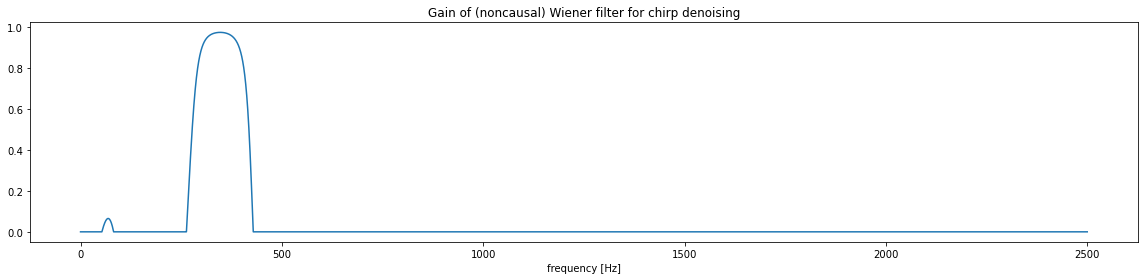

In [19]:
#Compute complex gain of Wiener non causal optimal filter
eps= np.min([1e-3,Pvv_den.max()/4.])  ;# small regularization parameter
G= np.maximum(1. - (Pvv_den+eps) / (Pyy_den),[0])
# Visualize the dsp
plt.figure(num=1,figsize=(16, 4))
plt.plot(fy,G)
plt.xlabel('frequency [Hz]')
plt.title('Gain of (noncausal) Wiener filter for chirp denoising')
plt.tight_layout()
plt.show()

In [20]:
#Compute optimal estimate of chirp signal
Y= 2*np.fft.rfft( sig_obs , n = 2*sig_len )
sig_filt= 2*np.real( np.fft.ihfft(Y*G,n=2*sig_len) )
sig_filt= sig_filt[:-1] # remove last point to recover original signal shape

/home/chatelaf/miniconda3/envs/calc/lib/python3.7/site-packages/numpy/fft/_pocketfft.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


### Display Wiener solution and play the optimal chirp estimate as a sound

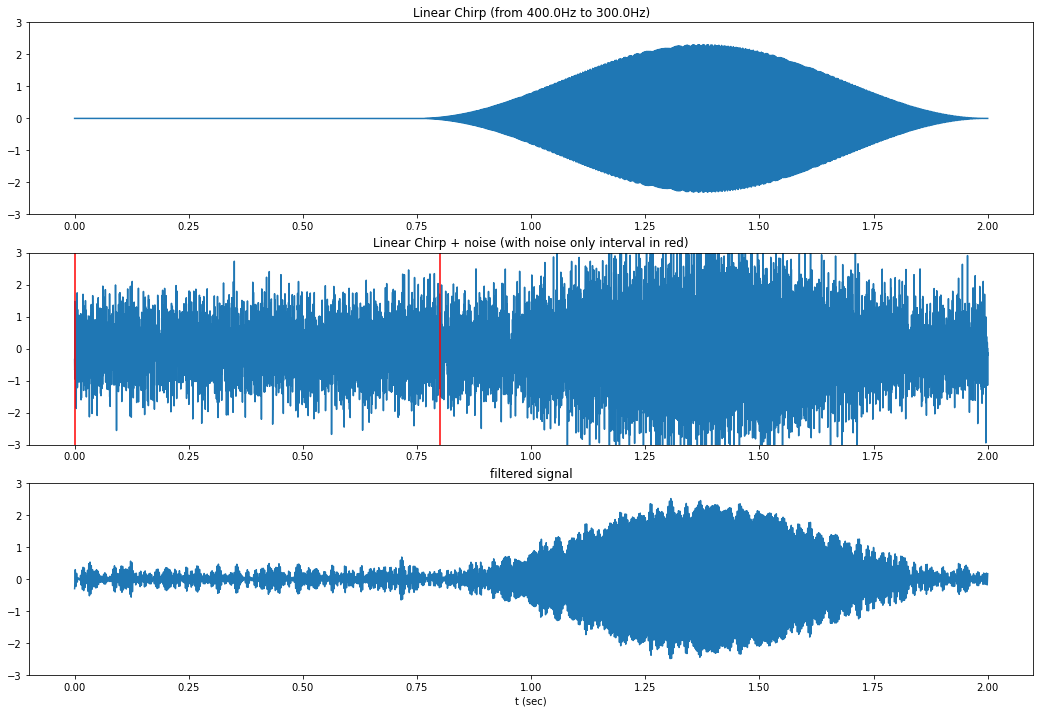

In [21]:
# Visualize the signals

plt.figure( num=2 , figsize=(18, 12) )

plt.subplot(3,1,1)

plt.plot(t, sig_chirp)
plt.ylim( -3, 3)   # set the ylim to ymin, ymax
plt.title("Linear Chirp (from {}Hz to {}Hz)".format(f0,f1) )
plt.subplot(3,1,2)
plt.plot(t, sig_obs)
plt.ylim( -3,3 )   # set the ylim to ymin, ymax
plt.plot([t[istart], t[istart]],[-3,3],'r')
plt.plot([t[iend], t[iend]],[-3,3],'r')
plt.title("Linear Chirp + noise (with noise only interval in red)")
plt.subplot(3,1,3)
plt.plot(t[::],sig_filt[::])
plt.ylim( -3, 3 )   # set the ylim to ymin, ymax
plt.title("filtered signal")
plt.xlabel('t (sec)')
plt.tight_layout
plt.show()

In [22]:
# Play filtered signal
from IPython.display import Audio
Audio(sig_filt / np.max(np.abs(sig_filt)), rate=fs)